# Hypothesis Testing: Insurance Data

In [1]:
# Imports 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Loading Data
df = pd.read_csv('Data/insurance - insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Checking for Duplicates and missing values
df.duplicated().sum()

1

In [4]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

In [6]:
df.duplicated().sum()

0

## Q1: Do smokers have higher insurance charges than non-smokers?

Null-Hypothesis: There is no significant difference in charges between smokers and non-smokers

Alternate Hypothesis: There is a significant difference in charges between smokers and non-smokers

In [7]:
# Creating groups for smokers & non-smokers
df['smoker'].value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

In [8]:
smokers_df = df.loc[df['smoker']=='yes'].copy()
non_smokers_df = df.loc[df['smoker']=='no'].copy()
smokers_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
11,62,female,26.29,0,yes,southeast,27808.7251
14,27,male,42.13,0,yes,southeast,39611.7577
19,30,male,35.30,0,yes,southwest,36837.4670
23,34,female,31.92,1,yes,northeast,37701.8768


In [9]:
# Defining features of interest
smokers_charges = smokers_df['charges']
non_smokers_charges = non_smokers_df['charges']

In [10]:
# Checking for outliers
smoker_zscores = stats.zscore(smokers_charges)
smoker_outliers = abs(smoker_zscores)>3
np.sum(smoker_outliers)

0

In [11]:
non_smoker_zscores = stats.zscore(non_smokers_charges)
non_smoker_outliers = abs(non_smoker_zscores)>3
np.sum(non_smoker_outliers)

24

In [12]:
# Removing outliers 
non_smokers_charges = non_smokers_charges[(np.abs(stats.zscore(non_smokers_charges)) < 3)]

In [13]:
equal_var_res = stats.levene(smokers_charges, non_smokers_charges)
print(equal_var_res)
print(equal_var_res.pvalue<.05)

LeveneResult(statistic=520.7178262969225, pvalue=2.512613039096279e-97)
True


In [14]:
# due to us not meeting our assumptions, we'll be running a Welch's T-Test due to unequal variance
ttest_result = stats.ttest_ind(smokers_charges,
                              non_smokers_charges,
                              equal_var=False)
print(ttest_result)
print(ttest_result.pvalue<.05)

Ttest_indResult(statistic=33.723466247187815, pvalue=2.7282718648018296e-104)
True


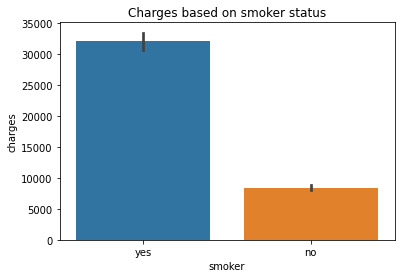

In [15]:
# concatenating previous dataframes and plotting
plotting_df_q1 = pd.concat([smokers_df, non_smokers_df])
ax=sns.barplot(data=plotting_df_q1, x = 'smoker', y='charges')
ax.set(title="Charges based on smoker status");

### Conclusion for Q1

For this hypothesis, with our p value being less than 0.05 we will reject the null hypothesis. "There is a significant difference in charges between smokers and non-smokers"

## Q2: Are men more likely to smoke than women?

Null-Hypothesis: There is no difference in the likeliness to smoke between men and women.

Alternate Hypothesis: Men are more likely to smoke than women.

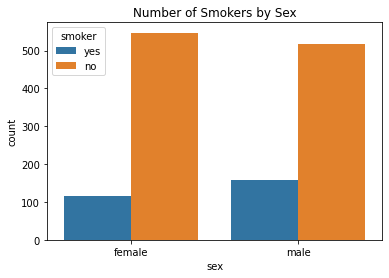

In [16]:
# visualizing smokers by sex 
ax = sns.countplot(data=df, x='sex', hue='smoker')
ax.set_title('Number of Smokers by Sex');

In [17]:
# Getting Contingency Table 

table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,516,159


In [18]:
# Results
smoker_sex_results = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = smoker_sex_results
print(p)
p<.05

0.0062765550120107375


True

### Conclusion for Q2: 

Due to our p value being less than 0.05 we'll be rejecting the null-hypothesis and supporting the alternate hypothesis: "Men are more likely to smoke than women."

## Q3: Do different regions have different charges, on average?

Null-Hypothesis: There is no significant difference in cost between regions.

Alternate Hypothesis: There is a significant difference in cost between regions. 

In [19]:
# creating groups for testing
df['region'].value_counts()

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64

In [20]:
groups = {}
for a in df['region'].unique():
    data=df.loc[df['region']==a, 'charges']
    groups[a] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [21]:
# Normal test for groups
norm_results = {}
for a, data in groups.items():
    stat,p = stats.normaltest(data)
    norm_results[a]= {'n': len(data),
                     'p':p,
                     'test stat':stat,}
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,324.0,6.502634e-24,106.779670
northeast,324.0,1.455431e-19,86.747629


In [22]:
# checking sig as recommended
norm_results_df['sig'] = norm_results_df['p'] <.05
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,324.0,6.502634e-24,106.779670,True
northeast,324.0,1.455431e-19,86.747629,True


Based on our p scores our data fails our normality assumption

In [23]:
# Testing Equal Variance Assumption
stats.levene(*groups.values())

LeveneResult(statistic=5.553479860699911, pvalue=0.0008689544824002284)

Based on the p value our data also fails our equal variance assumption. Due to our data failing both assumptions here we'll be running a Kruskal-Wallis test.

In [24]:
# Running Kruskal-Wallis Test
kruskal_results = stats.kruskal(*groups.values())
kruskal_results

KruskalResult(statistic=4.622506584464645, pvalue=0.20161983372311595)

Our p value for our results shows a that there is some sort of significant difference here. We'll run a Tukey's Pairwise Multiple Comparison test to find where the differences are.

In [25]:
# Running Tukey Pairwise test for comparison of groups 
from statsmodels.stats.multicomp import pairwise_tukeyhsd 
values = df['charges']
labels = df['region']
tukeys_results = pairwise_tukeyhsd(values, labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-955.5437,0.7457,-3397.7353,1486.648,False
northeast,southeast,1329.0269,0.4746,-1045.1237,3703.1776,False
northeast,southwest,-1059.4471,0.6793,-3499.7595,1380.8652,False
northwest,southeast,2284.5706,0.0643,-89.58,4658.7212,False
northwest,southwest,-103.9035,0.9995,-2544.2158,2336.4088,False
southeast,southwest,-2388.4741,0.0477,-4760.6915,-16.2567,True


Based on the previous Tukey Pairwise test we can see that the grouping that has an actual significant difference in the charges is between Southeast, and Southwest. Therefore, we will support the Alternate Hypothesis, "There is a significant difference in cost between regions." Those regions being Southeast and Southwest